In [3]:
#%run get_stock_prices.ipynb

In [4]:
from random import gauss
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objs as go
from datetime import timedelta
import plotly.express as px
%matplotlib inline

In [65]:
#ticker = input()

In [56]:
def predict_volatility(ticker):
    df = interval_to_df(ticker, "2y", "1d")
    returns = 100 * df["Close"].pct_change().dropna()
    returns_plot = px.line(returns,
                           title = f"{ticker} Returns over 2 Years",
                           labels = {"value":"Pct Change (%)", "Date":"Time"}
                          )
    model = arch_model(returns, p=2, q=2)
    model_fit = model.fit(disp="off")
    model_summary = model_fit.summary()
    
    # Rolling predictions over the last year
    rolling_predictions = []
    test_size = 365

    for i in range(test_size):
        train = returns[:-(test_size-i)]
        model = arch_model(train, p=2, q=2)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
    rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])
    
    rolling_volatility_plot = go.Figure()
    rolling_volatility_plot.add_trace(
        go.Scatter(
            x = df.index,
            y = returns[-365:],
            name = "Historical"
        )
    )
    rolling_volatility_plot.add_trace(
        go.Scatter(
            x = df.index,
            y = rolling_predictions,
            name = "Predicted"
        )
    )
    rolling_volatility_plot.update_layout(
        title_text = f"{ticker} Volatility Predictions Over Last 365 Days",
        xaxis = dict(title_text = "Last Year"),
        yaxis = dict(title_text = 'Percent Change (%)')
    )
    
    # Forecasting next 7 days
    pred = model_fit.forecast(horizon=7)
    future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
    pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)
    
    forecast_plot = go.Figure()
    forecast_plot.add_trace(
        go.Scatter(
            x = future_dates,
            y = pred,
            name = "Historical"
        )
    )
    forecast_plot.update_layout(
        title_text = f"{ticker} 7 Day Volatility Forecast",
        xaxis = dict(title_text = "Date"),
        yaxis = dict(title_text = 'Percent Change (%)')
    )
    '''
    px.line(pred,
                            title = f"{ticker} 7 Days Volatility Forecast",
                            labels = {"value":"Pct Change (%)", "Index":"Date"},
                            title_text = "Predicted Volatility"
                           )
    '''
    
    return returns_plot, model_summary, rolling_volatility_plot, forecast_plot

In [62]:
#returns_plot, model_summary, rolling_volatility_plot, forecast_plot = predict_volatility(ticker)

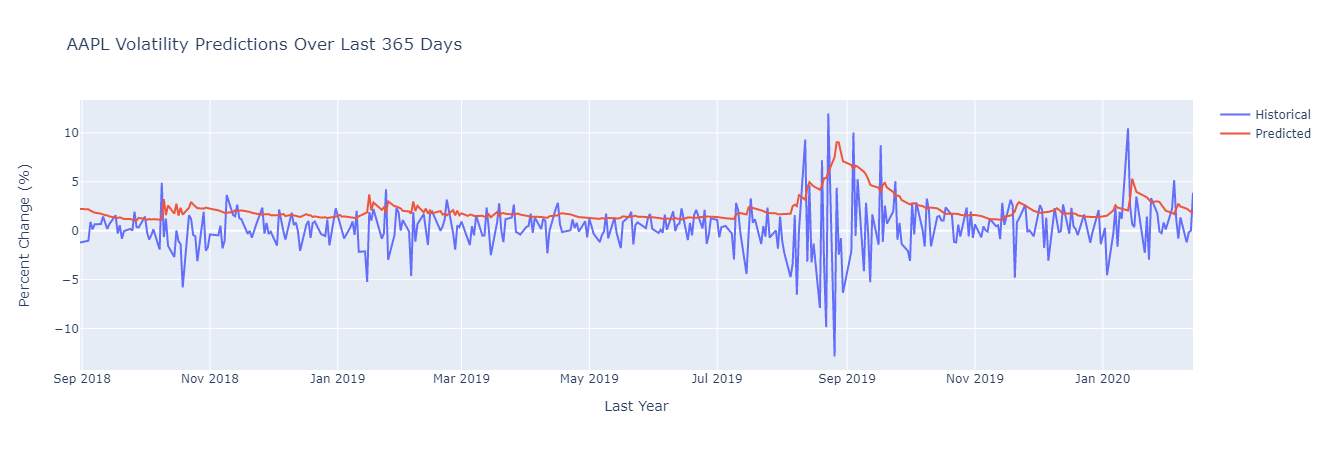

In [63]:
#rolling_volatility_plot

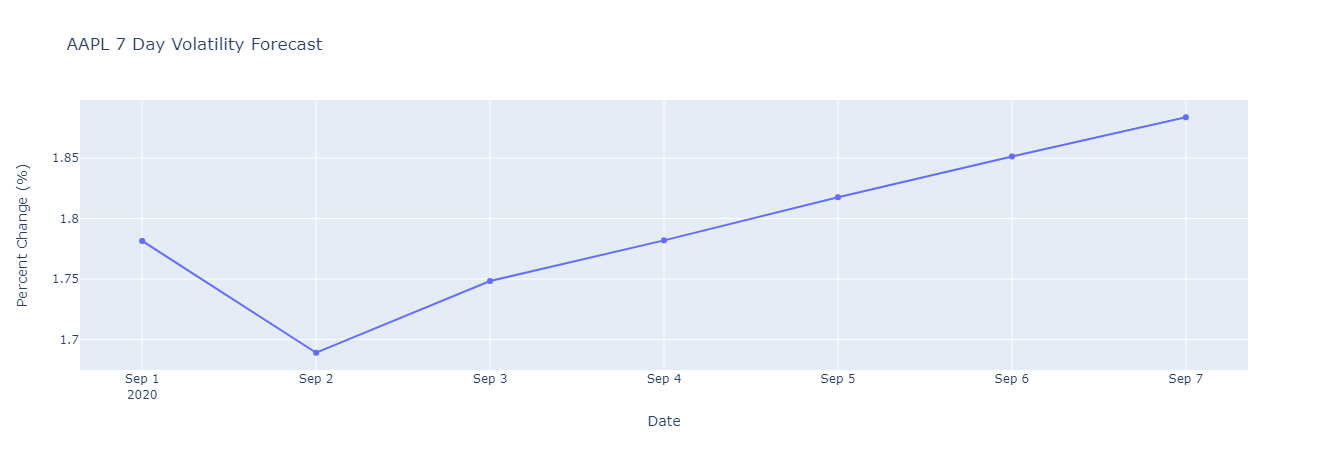

In [64]:
#forecast_plot